In [1]:
import torch
max_val = 30
def generate_data(batch_size, seq_len, max_val):
    # Generate random sequences of integers, drawing without replacement
    # to ensure unique values in each sequence
    inputs = torch.empty((batch_size, seq_len), dtype=torch.int64)
    for i in range(batch_size):
        inputs[i] = torch.randperm(max_val)[:seq_len]
    # Sort each sequence to get the target
    labels = torch.sort(inputs, dim=1).values
    return inputs, labels

# Example
inputs, labels = generate_data(batch_size=2, seq_len=10, max_val=max_val)
print("Inputs:\n", inputs)
print("Labels:\n", labels)

Inputs:
 tensor([[28, 14, 24,  6, 15, 25, 11,  4,  2, 22],
        [12, 24, 10, 14,  8,  9, 28,  2,  4,  0]])
Labels:
 tensor([[ 2,  4,  6, 11, 14, 15, 22, 24, 25, 28],
        [ 0,  2,  4,  8,  9, 10, 12, 14, 24, 28]])


In [2]:
import torch.nn as nn

class RnnSorter(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        # Use an embedding layer to represent numbers as vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # The RNN encoder
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        # A linear layer to map the output hidden states to our vocab
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x shape: [batch_size, seq_len]
        embedded = self.embedding(x)
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        # For simplicity, we use a very basic RNN structure
        # A proper encoder-decoder is better, but this is faster to code
        # and will still show the limitations.
        output, _ = self.rnn(embedded)
        # output shape: [batch_size, seq_len, hidden_dim]
        
        logits = self.fc(output)
        # logits shape: [batch_size, seq_len, vocab_size]
        return logits
    
    def predict(self, x):
        logits = self.forward(x)
        # Get the index of the max logit for each position
        _, predicted_indices = torch.max(logits, dim=2)
        return predicted_indices

In [3]:
# train the GRU model
epochs = 100
loss_fn = nn.CrossEntropyLoss()
batch_size = 32
model = RnnSorter(vocab_size=max_val, embedding_dim=16, hidden_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# print model architecture
print(f"Num of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

for epoch in range(epochs):
    optimizer.zero_grad()
    inputs, labels = generate_data(batch_size=32, seq_len=10, max_val=max_val)
    model = RnnSorter(vocab_size=max_val, embedding_dim=16, hidden_dim=32)
    
    # Convert inputs and labels to tensors
    inputs = inputs.to(torch.int64)
    labels = labels.to(torch.int64)
    
    # Forward pass
    outputs = model(inputs)
    
    # Compute loss (using CrossEntropyLoss for multi-class classification)
    loss = loss_fn(outputs.view(-1, max_val), labels.view(-1))
    
    # Backward pass and optimization would go here 
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Num of parameters: 6270
Epoch 0, Loss: 3.401395797729492
Epoch 10, Loss: 3.4023871421813965
Epoch 20, Loss: 3.4144349098205566
Epoch 30, Loss: 3.411207914352417
Epoch 40, Loss: 3.4094035625457764
Epoch 50, Loss: 3.410292863845825
Epoch 60, Loss: 3.394592761993408
Epoch 70, Loss: 3.415700912475586
Epoch 80, Loss: 3.4306480884552
Epoch 90, Loss: 3.4098122119903564


In [4]:

class SelfAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.output_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        # x shape: [batch_size, seq_len, embed_dim]
        B, L, E = x.shape
        
        # 1. Project to Q, K, V and split into heads
        # qkv shape: [B, L, E*3] -> [B, L, 3, num_heads, head_dim] -> [3, B, num_heads, L, head_dim]
        q, k, v = self.qkv_proj(x).reshape(B, L, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        
        # --- STUDENT TO IMPLEMENT ---
        # 2. Calculate attention scores (q @ k.transpose)
        # attn_scores shape: [B, num_heads, L, L]
        attn_scores = q @ k.transpose(-2, -1)
        
        # 3. Scale the scores
        # TODO: Scale by 1/sqrt(head_dim)
        attn_scores = attn_scores / (self.head_dim ** 0.5)
        
        # 4. Apply softmax
        # TODO: Apply softmax
        attn_weights = nn.Softmax(dim=-1)(attn_scores)
        
        # 5. Get the context vector by multiplying with V
        # context shape: [B, num_heads, L, head_dim]
        # TODO: Multiply attn_weights by V
        context = attn_weights @ v
        # --- END OF STUDENT IMPLEMENTATION ---
        
        # 6. Concatenate heads and project output
        context = context.transpose(1, 2).reshape(B, L, E)
        output = self.output_proj(context)
        
        return output, attn_weights # Return weights for visualization!
    
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=10):
        super().__init__()
        self.encoding = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(torch.log(torch.tensor(10000.0)) / embed_dim))
        
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Add batch dimension

    def forward(self, x):
        # print("Positional Encoding shape:", self.encoding.shape)
        # print("Input shape:", x.shape)
        return x + self.encoding[:, :x.size(1), :]

In [5]:
class AttentionSorter(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # sinusoidal postional encoding
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.attention_block = SelfAttentionBlock(embed_dim, num_heads)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        # x shape: [batch_size, seq_len]
        embedded = self.embedding(x)
        embedded = self.positional_encoding(embedded)
        # embedded shape: [batch_size, seq_len, embed_dim]
        
        attn_output, attn_weights = self.attention_block(embedded)
        # attn_output shape: [batch_size, seq_len, embed_dim]
        
        logits = self.fc(attn_output)
        # logits shape: [batch_size, seq_len, vocab_size]
        
        return logits, attn_weights
    
    # def predict(self, x):
    #     logits, _ = self.forward(x)
    #     # Get the index of the max logit for each position
    #     _, predicted_indices = torch.max(logits, dim=2)
    #     return logits, predicted_indices

In [6]:
model_attention = AttentionSorter(vocab_size=max_val, embed_dim=16, num_heads=4)
loss_fn_attention = nn.CrossEntropyLoss()
optimizer_attention = torch.optim.Adam(model_attention.parameters(), lr=0.001)
epochs = 30000

print(f"Num of parameters in Attention model: {sum(p.numel() for p in model_attention.parameters() if p.requires_grad)}")
for epoch in range(epochs):
    optimizer_attention.zero_grad()
    inputs, labels = generate_data(batch_size=64, seq_len=10, max_val=max_val)
    
    # Convert inputs and labels to tensors
    inputs = inputs.to(torch.int64)
    labels = labels.to(torch.int64)
    
    # Forward pass
    outputs, attn_weights = model_attention(inputs)
    
    # Compute loss
    loss = loss_fn_attention(outputs.view(-1, max_val), labels.view(-1))
    
    # Backward pass and optimization
    loss.backward()
    optimizer_attention.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Num of parameters in Attention model: 2078
Epoch 0, Loss: 3.432302474975586
Epoch 10, Loss: 3.4018077850341797
Epoch 20, Loss: 3.4038949012756348
Epoch 30, Loss: 3.391270399093628
Epoch 40, Loss: 3.3806145191192627
Epoch 50, Loss: 3.37367582321167
Epoch 60, Loss: 3.360039472579956
Epoch 70, Loss: 3.347409725189209
Epoch 80, Loss: 3.3195457458496094
Epoch 90, Loss: 3.2812328338623047
Epoch 100, Loss: 3.2323856353759766
Epoch 110, Loss: 3.190993070602417
Epoch 120, Loss: 3.1113474369049072
Epoch 130, Loss: 3.0564093589782715
Epoch 140, Loss: 2.994518518447876
Epoch 150, Loss: 2.943387508392334
Epoch 160, Loss: 2.9145560264587402
Epoch 170, Loss: 2.774430274963379
Epoch 180, Loss: 2.7561898231506348
Epoch 190, Loss: 2.716963291168213
Epoch 200, Loss: 2.6578948497772217
Epoch 210, Loss: 2.6142354011535645
Epoch 220, Loss: 2.5823283195495605
Epoch 230, Loss: 2.533994674682617
Epoch 240, Loss: 2.4431910514831543
Epoch 250, Loss: 2.455338954925537
Epoch 260, Loss: 2.45403790473938
Epoch 270, 

In [8]:
# let's evalutate the models one against the other
def evaluate_model(model, inputs, labels):
    model.eval()
    with torch.no_grad():
        outputs, _ = model(inputs)
        predicted_indices = torch.argmax(outputs, dim=2)
        #print(outputs[:10])
        print(inputs[:10])
        print(predicted_indices[:10])
        correct = (predicted_indices == labels).float().sum()
        accuracy = correct / (inputs.size(0) * inputs.size(1))
    return accuracy.item()

test_inputs, test_labels = generate_data(batch_size=100, seq_len=10, max_val=max_val)
#accuracy_rnn = evaluate_model(model, test_inputs, test_labels)
accuracy_attention = evaluate_model(model_attention, test_inputs, test_labels)
#print(f'RNN Model Accuracy: {accuracy_rnn:.4f}')
print(f'Attention Model Accuracy: {accuracy_attention:.4f}')

tensor([[13,  6,  3, 24, 27, 17, 18, 10,  9, 21],
        [ 0, 11, 26, 15, 22,  8, 10, 21, 12,  9],
        [23, 29,  4, 18, 22, 12, 24,  0,  1, 20],
        [ 8, 29, 20, 17, 16,  3, 24, 14, 26, 23],
        [ 3, 13, 24, 19,  1,  8, 23,  5, 26,  2],
        [22, 15, 17,  0,  8, 24, 13, 27,  2, 25],
        [ 7,  3, 22,  0,  4, 12, 26, 24, 28,  9],
        [23, 18, 22,  6,  7, 16,  3,  0,  1, 29],
        [23, 12, 17, 26,  7,  0,  3, 18,  4, 25],
        [27, 25, 18, 20, 10,  8, 22, 12,  2,  3]])
tensor([[ 3,  6,  9, 10, 13, 17, 18, 21, 24, 27],
        [ 0,  8,  9, 10, 11, 12, 15, 21, 22, 26],
        [ 0,  1,  4, 12, 18, 20, 22, 22, 24, 29],
        [ 3,  8, 14, 16, 17, 20, 23, 24, 26, 29],
        [ 1,  2,  3,  5,  8, 13, 19, 23, 24, 26],
        [ 0,  2,  8, 13, 15, 17, 22, 24, 25, 27],
        [ 0,  3,  4,  7,  9, 12, 22, 24, 26, 28],
        [ 0,  1,  3,  6,  7, 16, 18, 22, 23, 29],
        [ 0,  3,  4,  7, 12, 17, 18, 23, 25, 26],
        [ 2,  3,  8, 10, 12, 18, 20, 22, 25, 27]]

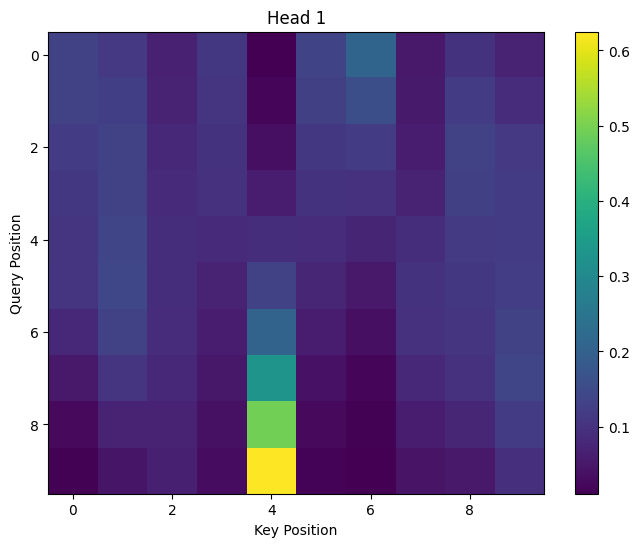

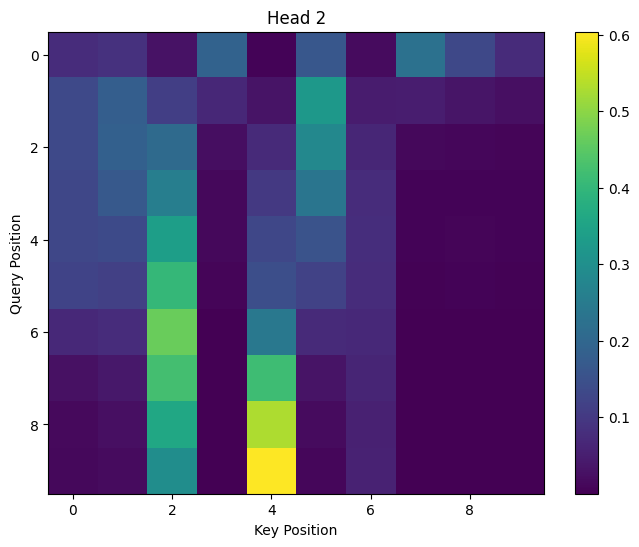

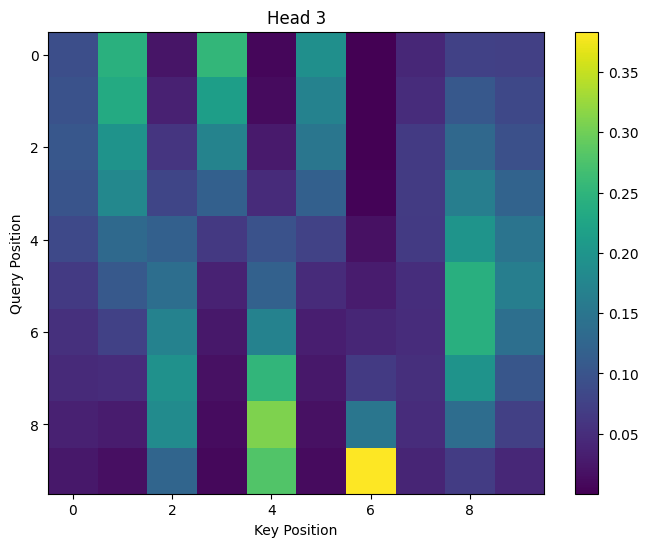

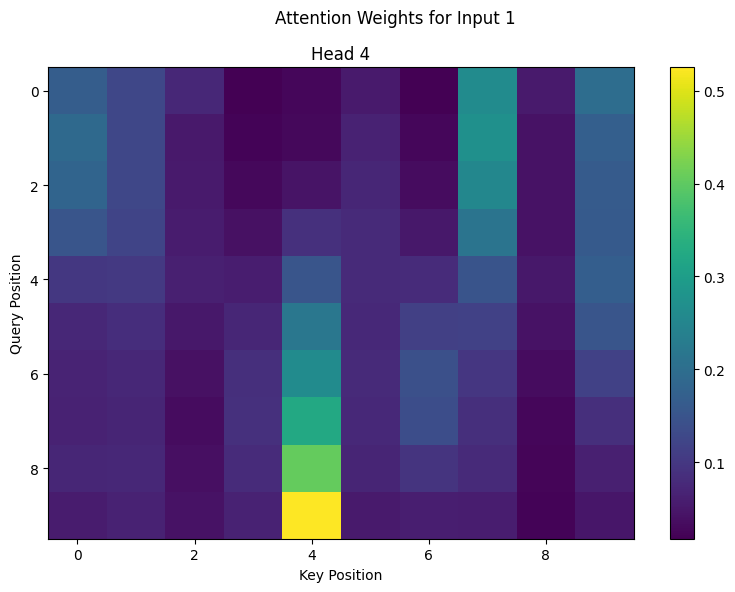

In [ ]:
# let us visualize the attention weights
import matplotlib.pyplot as plt
def visualize_attention_weights(attn_weights, inputs, labels):
    # attn_weights shape: [batch_size, num_heads, seq_len, seq_len]
    # inputs shape: [batch_size, seq_len]
    
    batch_size, num_heads, seq_len, _ = attn_weights.shape
    attn_weights = attn_weights.cpu().detach()  # Move to CPU for visualization
    
    for i in range(batch_size):
        for h in range(num_heads):
            plt.figure(figsize=(8, 6))
            plt.imshow(attn_weights[i, h].cpu().numpy(), cmap='viridis', aspect='auto')
            plt.title(f'Head {h + 1}')
            plt.xlabel('Key Position')
            plt.ylabel('Query Position')
            plt.colorbar()
        plt.suptitle(f'Attention Weights for Input {i + 1}')
        plt.tight_layout()
        plt.show()
        
test_inputs, test_labels = generate_data(batch_size=1, seq_len=10, max_val=max_val)
attn_weights = model_attention(test_inputs)[1]  # Get attention weights from the model       
# Visualize attention weights for the first batch of inputs
visualize_attention_weights(attn_weights, test_inputs, test_labels)